## _Explore Hits_

- Perform _EDA_ on _hits_ Data.

In [1]:
import sys, os, glob, yaml

In [2]:
import math
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trackml.dataset
import seaborn as sns

In [4]:
sys.path.append('src')

### _Dataset_

In [5]:
# mu- data (old)
# input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (current)
# input_dir = './data_sets/pandaml/data_0.1_1.5_GeV/'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [6]:
input_dir = "./data"

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [8]:
file_prefixes[:10]

['./data/event0000000000',
 './data/event0000000001',
 './data/event0000000002',
 './data/event0000000003',
 './data/event0000000004',
 './data/event0000000005',
 './data/event0000000006',
 './data/event0000000007',
 './data/event0000000008',
 './data/event0000000009']

In [9]:
event_id = 0
event_prefix = file_prefixes[event_id]

In [10]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

## Hits

The hits file contains the following values for each hit/entry:

* __hit_id__: numerical identifier of the hit inside the event.
* __x, y, z__: measured x, y, z position (in millimeter) of the hit in global coordinates.
* __volume_id__: numerical identifier of the detector group.
* __layer_id__: numerical identifier of the detector layer inside the group.
* __module_id__: numerical identifier of the detector module inside the layer.


Here we have the $x, y, z$ global coordinates (in cm) of where the particles hit the detector surface. The volume/layer/module id could in principle be deduced from x, y, z. They are given here to simplify detector-specific data handling.

In [11]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-4.57218,1.089970,14.780000,2,13,367
1,2,-2.13939,0.663788,6.980000,2,11,344
2,3,1.89899,4.346520,-3.207740,2,6,23
3,4,2.11633,0.776864,-0.780989,2,1,26
4,5,2.30500,-4.161470,6.980000,2,7,281


#### _Fix volume_id and layer_id for MVD, GEM, STT, STT Skewed in radial order_

In [12]:
hits.volume_id.unique()

array([2, 3, 6, 9], dtype=int32)

In [13]:
hits.layer_id.unique()

array([13, 11,  6,  1,  7,  5, 12, 14,  2, 17, 20, 15, 16, 23, 24, 25, 26,
       27, 28,  0,  3,  4, 18, 19, 21, 22,  9], dtype=int32)

In [14]:
hits.loc[hits['volume_id'] == 2, 'layer_id'].unique()

array([13, 11,  6,  1,  7,  5, 12, 14,  2], dtype=int32)

In [15]:
hits.loc[hits['volume_id'] == 3, 'layer_id'].unique()

array([17, 20, 15, 16], dtype=int32)

In [16]:
hits.loc[hits['volume_id'] == 6, 'layer_id'].unique()

array([23, 24, 25, 26, 27, 28], dtype=int32)

In [17]:
hits.loc[hits['volume_id'] == 9, 'layer_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25,  9, 11, 13, 15], dtype=int32)

In [18]:
vlids = [   (2, 1), # MVDPixel
            (2, 2),
            (2, 3),
            (2, 4),
            (2, 5),
            (2, 6),
            (2, 7),
            (2, 8),
            (2, 9),
            (2, 10),
            (2, 11),
            (2, 12),
            (2, 13),
            (2, 14),
            (2, 15),
            (2, 16),
            (2, 17),
            (2, 18),
            (2, 19),
            (2, 20),
            (2, 21),
            (2, 22),    
            (6, 23), # GEM
            (6, 24),
            (6, 25),
            (6, 26),
            (6, 27),
            (6, 28),
            (9, 0),  # STT
            (9, 1),
            (9, 2),
            (9, 3),
            (9, 4),
            (9, 5),
            (9, 6),
            (9, 7),
            (9, 8),
            (9, 9),
            (9, 10),
            (9, 11),
            (9, 12),
            (9, 13),
            (9, 14),
            (9, 15),
            (9, 16),
            (9, 17),
            (9, 18),
            (9, 19),
            (9, 20),
            (9, 21),
            (9, 22),
            (9, 23),
            (9, 24),
            (9, 25)
        ]

In [19]:
# Lets build our own volume_id, layer_id tuples from hits dataframe

In [20]:
# n_det_layers
hits.layer_id.unique().shape[0]

27

In [21]:
hits.volume_id.unique().shape[0]

4

In [22]:
# Get Group, Drop Duplicates and Sort
vlids = hits[['volume_id', 'layer_id']].drop_duplicates()
vlids = vlids.sort_values(['volume_id', 'layer_id'], ascending=[True, True])

In [23]:
vlids.head()

,volume_id,layer_id
3,2,1
18,2,2
10,2,5
2,2,6
4,2,7


In [24]:
vlids = list(zip(vlids.volume_id, vlids.layer_id))

In [25]:
vlids

[(2, 1),
 (2, 2),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 20),
 (6, 23),
 (6, 24),
 (6, 25),
 (6, 26),
 (6, 27),
 (6, 28),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 9),
 (9, 11),
 (9, 13),
 (9, 15),
 (9, 16),
 (9, 17),
 (9, 18),
 (9, 19),
 (9, 20),
 (9, 21),
 (9, 22),
 (9, 23),
 (9, 24),
 (9, 25)]

In [26]:
n_det_layers = len(vlids)
vlid_groups = hits.groupby(["volume_id", "layer_id"])

In [27]:
vlid_groups.groups

{(2, 1): [3, 5], (2, 2): [18], (2, 5): [10, 11, 12], (2, 6): [2, 8, 9, 15], (2, 7): [4], (2, 11): [1, 6, 19], (2, 12): [13, 17], (2, 13): [0, 7], (2, 14): [14, 16], (3, 15): [23, 24, 25, 26, 31, 33], (3, 16): [34], (3, 17): [20, 21, 27, 28, 32], (3, 20): [22, 29, 30], (6, 23): [35, 37, 38], (6, 24): [36, 39], (6, 25): [40, 42, 43], (6, 26): [41, 44], (6, 27): [45, 47], (6, 28): [46, 48], (9, 0): [49, 67, 75, 93, 109, 126, 139, 147, 163], (9, 1): [50, 68, 76, 94, 110, 127, 140, 148, 164], (9, 2): [51, 69, 77, 95, 111, 128, 141, 149, 165], (9, 3): [52, 70, 78, 96, 112, 129, 142, 150, 166], (9, 4): [53, 71, 79, 97, 113, 130, 143, 151, 167], (9, 5): [54, 72, 80, 98, 114, 131, 144, 152, 168], (9, 6): [55, 73, 81, 99, 115, 132, 145, 153, 169], (9, 7): [56, 74, 82, 100, 116, 133, 146, 154, 170, 180, 181, 190, 191, 196, 197, 206, 223, 234, 235, 240, 245, 246], (9, 9): [182, 183, 192, 198, 207, 208, 209, 224, 225, 226, 236, 241, 247, 248], (9, 11): [184, 185, 193, 199, 200, 201, 210, 213, 214, 

In [28]:
vlid_groups.get_group(vlids[0])

,hit_id,x,y,z,volume_id,layer_id,module_id
3,4,2.11633,0.776864,-0.780989,2,1,26
5,6,2.64012,1.042310,-2.403120,2,1,25


- Issue is some groups are missing in the data.
- We need to build `vlids` from the dataframe and then rename layers from `0,1,2,...,54`
- n_det_layers = hits.layer_id.unique()

In [29]:
def get_vlids(hits):
    vlids = hits[['volume_id', 'layer_id']].drop_duplicates()
    vlids = vlids.sort_values(['volume_id', 'layer_id'], ascending=[True, True])
    vlids = list(zip(vlids.volume_id, vlids.layer_id))
    return vlids

In [30]:
vlids = get_vlids(hits)

In [31]:
len(vlids)

41

In [44]:
hits.layer_id.unique().shape[0]

41

In [32]:
vlids

[(2, 1),
 (2, 2),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 20),
 (6, 23),
 (6, 24),
 (6, 25),
 (6, 26),
 (6, 27),
 (6, 28),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 9),
 (9, 11),
 (9, 13),
 (9, 15),
 (9, 16),
 (9, 17),
 (9, 18),
 (9, 19),
 (9, 20),
 (9, 21),
 (9, 22),
 (9, 23),
 (9, 24),
 (9, 25)]

In [33]:
hits.layer_id.unique()

array([13, 11,  6,  1,  7,  5, 12, 14,  2, 17, 20, 15, 16, 23, 24, 25, 26,
       27, 28,  0,  3,  4, 18, 19, 21, 22,  9], dtype=int32)

In [34]:
hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer_id=i) for i in range(n_det_layers)])

In [35]:
hits.layer_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])

In [36]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
3,4,2.116330,0.776864,-0.780989,2,0,26
5,6,2.640120,1.042310,-2.403120,2,0,25
18,19,0.893001,1.983650,1.980000,2,1,272
10,11,-1.739660,-1.264310,4.420000,2,2,333
11,12,-0.900623,1.526720,3.980000,2,2,331


In [37]:
vlids = get_vlids(hits)

In [38]:
vlids

[(2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (6, 17),
 (6, 18),
 (9, 19),
 (9, 20),
 (9, 21),
 (9, 22),
 (9, 23),
 (9, 24),
 (9, 25),
 (9, 26),
 (9, 27),
 (9, 28),
 (9, 29),
 (9, 30),
 (9, 31),
 (9, 32),
 (9, 33),
 (9, 34),
 (9, 35),
 (9, 36),
 (9, 37),
 (9, 38),
 (9, 39),
 (9, 40)]

In [39]:
# Calculate derived hits variables
r = np.sqrt(hits.x**2 + hits.y**2)
phi = np.arctan2(hits.y, hits.x)

# Merge `hits` with `truth`, but first add `r` & `phi`
hits = hits.assign(r=r, phi=phi).merge(truth, on="hit_id")

# Add `event_id` column to this event.
# hits = hits.assign(event_id=int(event_file[-10:]))

In [40]:
hits

,hit_id,x,y,z,volume_id,layer_id,module_id,r,phi,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,4,2.116330,0.776864,-0.780989,2,0,26,2.254411,0.351810,2.106560,0.774229,-0.777399,1.294080,0.472316,-0.476282,1.0,6
1,6,2.640120,1.042310,-2.403120,2,0,25,2.838423,0.376013,2.631460,1.037290,-2.394990,0.525116,0.213791,-0.479275,1.0,4
2,19,0.893001,1.983650,1.980000,2,1,272,2.175389,1.147792,0.888615,1.973640,1.970000,0.295761,0.648628,0.649246,1.0,9
3,11,-1.739660,-1.264310,4.420000,2,2,333,2.150557,-2.513134,-1.735840,-1.259670,4.410000,-0.327827,-0.241509,0.840340,1.0,2
4,12,-0.900623,1.526720,3.980000,2,2,331,1.772568,2.103762,-0.900665,1.523590,3.970000,-0.197713,0.328847,0.859544,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,109,16.618999,-35.855000,35.000000,9,39,4440,39.519264,-1.136768,16.511200,-35.894501,58.406200,0.268992,-0.734475,1.159730,1.0,7
250,160,-24.491199,31.309999,35.000000,9,39,4395,39.750912,2.234599,-24.388201,31.417900,89.234596,-0.274611,0.261989,0.846925,1.0,5
251,280,13.995000,37.369999,35.000000,9,39,4486,39.904598,1.212466,14.091800,37.339901,-21.051800,0.293452,0.944971,-0.522851,1.0,1
252,75,19.243099,35.349998,35.000000,9,40,4539,40.248222,1.072294,19.388800,35.252800,36.856300,0.391961,0.587672,0.647115,1.0,9


## The $x, y, z$ Distributions

### (+) Vertical Intersection ($x, y$) in Detection Layers

As shown in the figure below, the hits are semi evenly distributed on the detector surface $x, y$.  The white circle in the center of the plot is where the beam pipe lies.  Thanks [agerom] for [the clarification][clar].

The colors represent different detector volumes.  Thanks to [Joshua Bonatt's notebook][josh].

[josh]: https://www.kaggle.com/jbonatt/trackml-eda-etc
[clar]: https://www.kaggle.com/wesamelshamy/trackml-problem-explanation-and-data-exploration/comments#323803
[agerom]: https://www.kaggle.com/artemiosgeromitsos

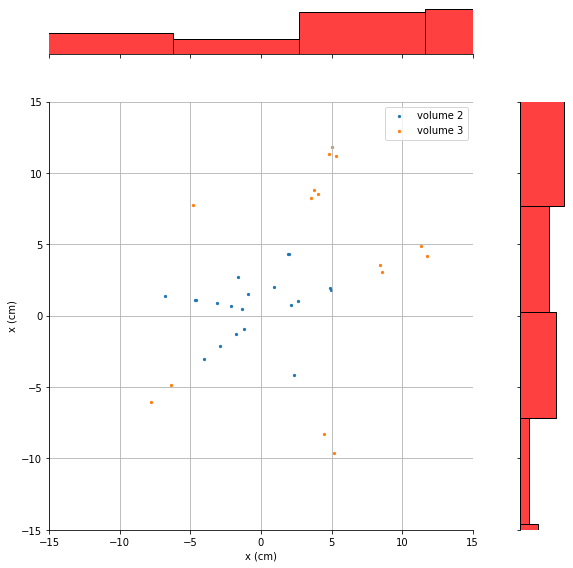

In [41]:
# Plotting with Seaborn & Matplotlib:
g = sns.jointplot(data=hits, x='x', y='y', space=1, height=8, color="r")
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in [2,3]:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=5, label='volume {}'.format(volume))

plt.xlabel('x (cm)')
plt.ylabel('x (cm)')
plt.xlim((-15,15))
plt.ylim((-15,15))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend(fontsize=10, loc='best')
#plt.savefig("xy_barrel.pdf")

### (+) Horizonal Intersection ($y, z$) in Detection Layers
You can think of the chart below as a horizontal intersection in the detection surface, where every dot is a hit.  Notice the relationship between the different activity levels in this chart and the one above for $x, y$.

Again, the colors represent different volumes in the detector surface.

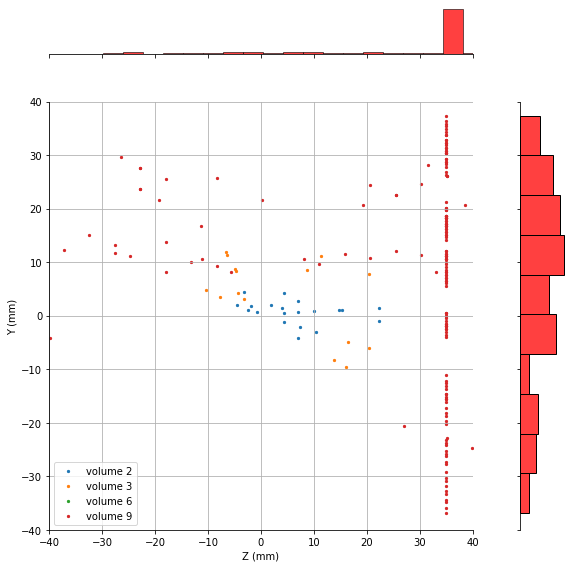

In [42]:
g = sns.jointplot(data=hits, x='z', y='y', space=1, height=8, color="r")
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=5, label='volume {}'.format(volume))
    
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.xlim((-40,40))
plt.ylim((-40,40))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend(fontsize=10, loc='best')
plt.show()

### (+) 3D Intersection ($x, y, z$) in Detection Layers

And here is how the hits in this event look like in 3D.  Again, a sample from one event.  This combines the previous two charts in 3D.

Notice how the particles penetrate the detector surface along $z$ coordinate.

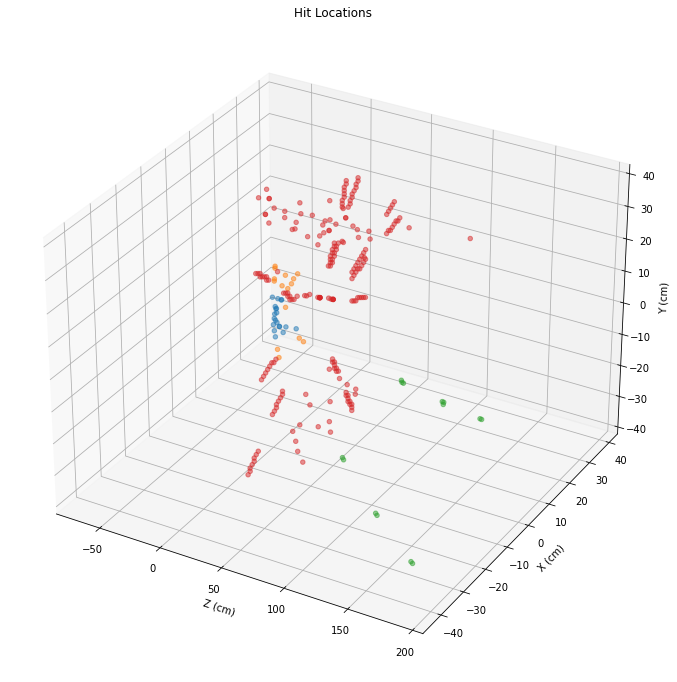

In [43]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, label='volume {}'.format(volume), alpha=0.5)

ax.set_title('Hit Locations')
ax.set_xlabel('Z (cm)')
ax.set_ylabel('X (cm)')
ax.set_zlabel('Y (cm)')
plt.show()